In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy
from scipy.optimize import fsolve
from math import factorial

In [41]:
M = 3   # number of large JJs in a SNAIL
EJ = 90 * 2*np.pi   # junction energy of larger JJ 
EL = 64 * 2*np.pi   # linear inductive energy of the SNAIL
EC = 177e-3 * 2*np.pi   # charging energy of the SNAIL 
beta = 0.147   # ratio between small and large JJ 
phi_ext = 0.43 * 2*np.pi   # external flux in SNAIL, e.g., 2pi = 1 flux quantum 

w_a = 2.976018 * 2*np.pi   # frequency of Alice mode 
w_b = 6.915945 * 2*np.pi   # frequency of Bob mode 

g_ac = 75.6e-3 * 2*np.pi   # coupling strength between Alice and SNAIL
g_bc = 134.9e-3 * 2*np.pi   # coupling strength between Bob and SNAIL 

dim_SNAIL = 5   # level cutoff of SNAIL using oscillator basis (expanded around the equilibrium in potential)
dim_alice = 3   # level cutoff of Alice using oscillator basis 
dim_bob = 3   # level cutoff of Bob using oscillator basis 
dim = dim_SNAIL * dim_bob   # total dimension of the coupled system 

In [42]:
c_opt = tensor(destroy(dim_SNAIL), qeye(dim_bob))   # annihilation operator of SNAIL  
b_opt = tensor(qeye(dim_SNAIL), destroy(dim_bob))   # annihilation operator of Bob  

In [43]:
def potential_min(phi_min, phi_ext):
    return beta * np.sin(phi_min - phi_ext) + np.sin(phi_min/M)

In [384]:
phi_min = fsolve(potential_min, 0, args=phi_ext)[0]
c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

p = EL / (c2 * EJ + EL)

# renormalized coefficient due to the linear inductor [ref. B9]
c2_ti = p * c2
c3_ti = p**3 * c3
c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

# zero point fluctuation of the linearized SNAIL
phi_c = (2*EC / c2_ti / EJ)**0.25

# analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
wc = np.sqrt(8*c2_ti*EC*EJ)
g3 = EJ * phi_c**3 * c3_ti / factorial(3)
g4 = EJ * phi_c**4 * c4_ti / factorial(4)
g5 = EJ * phi_c**5 * c5_ti / factorial(5)

In [806]:
wc/2/np.pi

4.649771256958445

In [807]:
0.06*130

7.8

In [385]:
shift = g_bc**2/(wc-w_b)

In [386]:
h_SNAIL = (wc)* c_opt.dag() * c_opt + g3 * (c_opt + c_opt.dag())**3 + g4 * (c_opt + c_opt.dag())**4 +g5 * (c_opt + c_opt.dag())**5 
h_tot = (h_SNAIL + (w_b) * b_opt.dag() * b_opt -1j* g_bc * (b_opt.dag()*c_opt-b_opt*c_opt.dag()))

In [932]:
gamma = 1/100
c_ops = [np.sqrt(2*gamma) * c_opt.dag() * c_opt]  # collapse operator for dephasing

In [933]:
# h_tot.eigenstates()[0]/2/np.pi

In [934]:
dressed_states = h_tot.eigenstates()[1]

In [935]:
(h_tot.eigenstates()[0][1]-h_tot.eigenstates()[0][0])/2/np.pi

4.645088231008725

In [936]:
psi0.dag()*sx*psi0

(0.07629750284292618-9.125237952979593e-18j)

In [937]:
g = dressed_states[0]
e = dressed_states[2]
sx = g*e.dag()+e*g.dag()

In [938]:
psi0 = (g + e).unit() 

In [939]:
def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

In [940]:
options = {'atol': 1e-10, 'rtol': 1e-10}
omega = 4.64*2*np.pi
A = 3e-3*2*np.pi
func = gaussian_ramp(700,700, A)
time = 700
tlist_up = np.linspace(0, time, 10000) 
tlist_down = np.linspace(0, time, 10000) 
Hc = -1j*(c_opt-c_opt.dag())

In [941]:

H = [h_tot, [Hc, lambda t: func(t)*np.cos(omega*t)]]
U_up = propagator(H, tlist_up, options=options)[-1]
U_down = propagator(H, tlist_down, options=options)[-1]

In [942]:
psi0 = (g + e).unit() 
psi0= U_up*psi0

In [943]:
H = [h_tot, [Hc, lambda t: A*np.cos(omega*t)]]

In [944]:
times = np.linspace(0, 1000, 20000)  # time range for the Ramsey experiment
# Time evolution

result = mesolve(H, psi0, times, c_ops,)


In [1017]:
def sample_arrays(array1, array2, m,U):
    # Calculate the indices to sample every m elements
    indices = np.arange(0, len(array1), m)
    
    # Sample the elements
    sampled_array1 = [array1[i] for i in indices]
    sampled_array2 = [expect(sx,U*array2[i]*U.dag()) for i in indices]
    
    return np.array(sampled_array1), np.array(sampled_array2)
m=10
times1,ramsey_signal1 = sample_arrays(times,result.states, m,U_down)

In [1028]:
from scipy.optimize import curve_fit
# Function to model Ramsey fringes (with decay)
def ramsey_fringe(t, A, B, T2, omega):
    return np.exp(-t / T2)*np.cos(omega*t+B)

# Fit the model to the simulated data
popt, pcov = curve_fit(ramsey_fringe, times1, ramsey_signal1, p0=[1, 0., 10000000, 1e1], maxfev=100000)


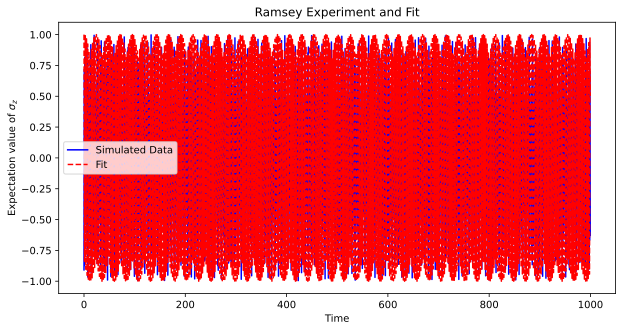

Extracted T2 (dephasing time): 10000000.00


In [1029]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(times1, ramsey_signal1, 'b-', label='Simulated Data')
plt.plot(times1, ramsey_fringe(times1, *popt), 'r--', label='Fit')
plt.title('Ramsey Experiment and Fit')
plt.xlabel('Time')
plt.ylabel('Expectation value of $\\sigma_z$')
plt.legend()
plt.show()

# Print the dephasing rate T2
print("Extracted T2 (dephasing time): {:.2f}".format(popt[2]))

In [949]:
g_bc/(w_b-wc)

0.059527651140703526

In [950]:
(w_b-wc)/2/np.pi

2.2661737430415547